In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [3]:
chosen = ["football", "formula1", "kabaddi", "cricket", "tennis", "hockey",'table_tennis']
count_classes = len(chosen)

In [4]:
data = []
count_images = 0
for dirname, _, filenames in os.walk('/kaggle/input/sports-image-dataset/data'):
    for filename in filenames:
        count_images += 1
        #print(os.path.join(dirname, filename))
        label = dirname.split('/')[-1]
        image_properties = [os.path.join(dirname, filename), label]
        if label in chosen:
            data.append(image_properties)
        
df = pd.DataFrame(data, columns=["Path", "Label"])
df["ToLowerPath"] = df["Path"].str.lower()
df.shape

(4580, 3)

In [6]:
count_images

14324

In [7]:
other = df[~df["ToLowerPath"].str.endswith("jpg") & ~df["ToLowerPath"].str.endswith("png") & ~df["ToLowerPath"].str.endswith("jpeg")]
df = df[df["ToLowerPath"].str.endswith("jpg") | df["ToLowerPath"].str.endswith("png") | df["ToLowerPath"].str.endswith("jpeg")]

In [8]:
other["FileName"] = other["Path"].str.split('/')
other["FileName"].tolist()
for i in range(other.shape[0]):
    val = other.iloc[[i]]
    val = val["FileName"].tolist()[0][-1]

In [9]:
df.shape

(4497, 3)

100%|██████████| 15/15 [00:01<00:00, 11.29it/s]


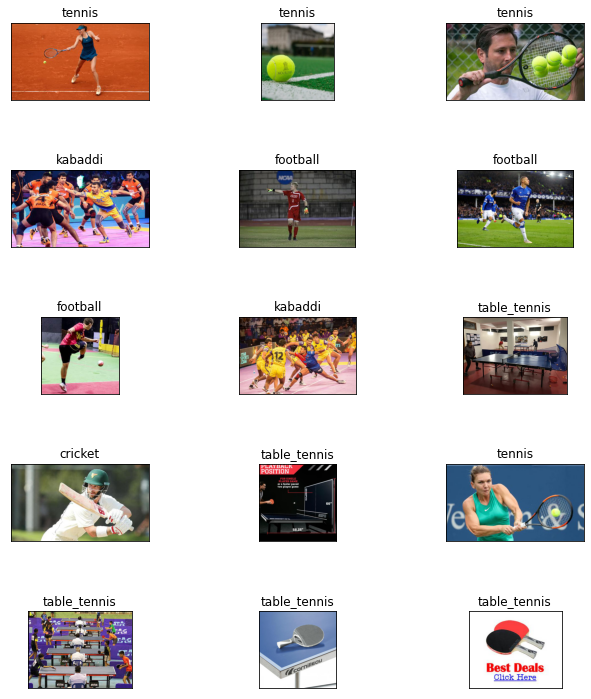

In [10]:
random_imgs = [random.randrange(0, df.shape[0], 1) for i in range(15)]
plt.figure(figsize=(10,10))
for i in tqdm(range(15)):
    plt.subplot(5,3,i+1)
    plt.tight_layout(h_pad=5)
    random_img = df.iloc[[random_imgs[i]]]
    img=Image.open(random_img["Path"].item())
    plt.title(random_img["Label"].item())
    plt.xticks(())
    plt.yticks(())
    plt.imshow(img)
plt.show()

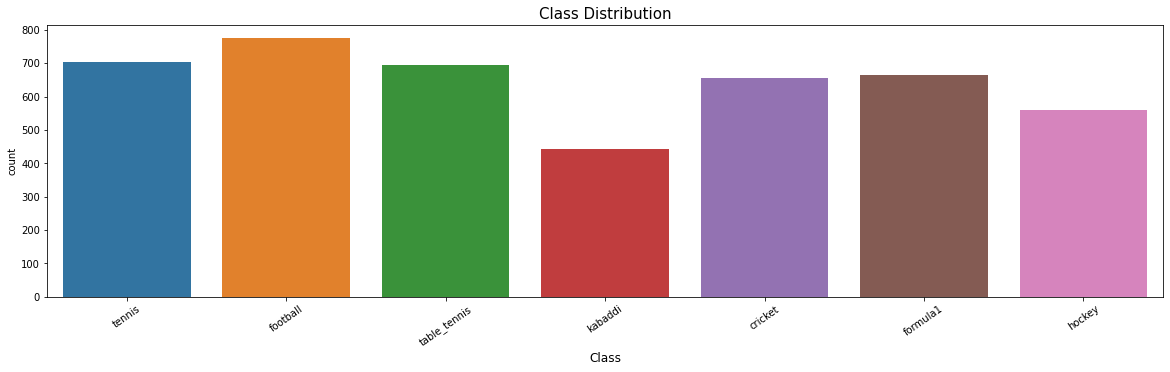

In [11]:
plt.figure(figsize=(20,5))
sns.countplot(df["Label"], palette = sns.color_palette("tab10", 22))
plt.title('Class Distribution', fontsize = 15)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=35)
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
labels = np.array([label for label in df['Label']])
enc = LabelEncoder()
labels = enc.fit_transform(labels)
df["LabelNumber"] = labels
df.head()

,Path,Label,ToLowerPath,LabelNumber
0,/kaggle/input/sports-image-dataset/data/tennis...,tennis,/kaggle/input/sports-image-dataset/data/tennis...,6
1,/kaggle/input/sports-image-dataset/data/tennis...,tennis,/kaggle/input/sports-image-dataset/data/tennis...,6
2,/kaggle/input/sports-image-dataset/data/tennis...,tennis,/kaggle/input/sports-image-dataset/data/tennis...,6
3,/kaggle/input/sports-image-dataset/data/tennis...,tennis,/kaggle/input/sports-image-dataset/data/tennis...,6
4,/kaggle/input/sports-image-dataset/data/tennis...,tennis,/kaggle/input/sports-image-dataset/data/tennis...,6


In [13]:
df.groupby(["LabelNumber"]).count()

,Path,Label,ToLowerPath
LabelNumber,,,
0,656,656,656
1,776,776,776
2,665,665,665
3,559,559,559
4,442,442,442
5,696,696,696
6,703,703,703


In [14]:
def class_count(df):
    grp = df.groupby(["Label"]).count().reset_index()
    grp.rename(columns = {'Path':'Count'}, inplace = True)
    #return {key: grp[key] for key in list(grp.keys())}
    return grp

def class_proportion(df):
    classes_count = class_count(df)
    #return {val[0]: (round(val[1]/df.shape[0], 3))*100 for val in classes_count.items()}
    count_all = classes_count["Count"].sum()
    classes_count["Proportion"] = (round(classes_count["Count"]/count_all, 3))*100
    return classes_count

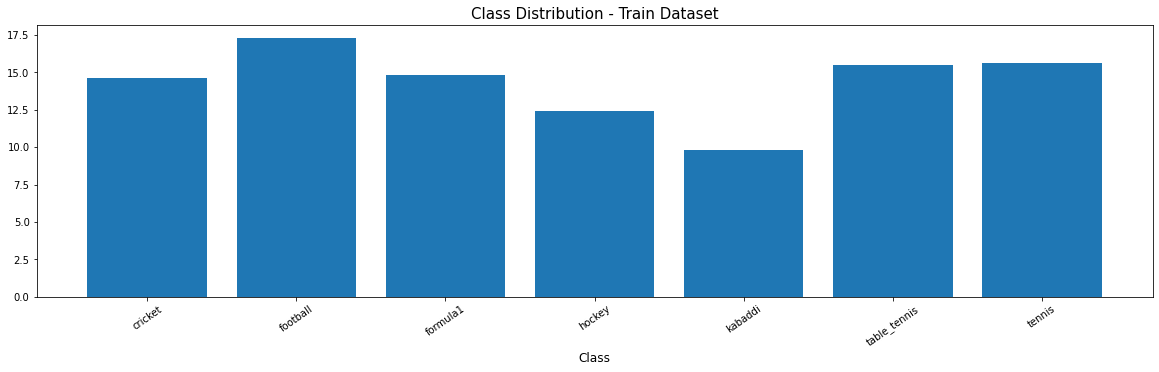

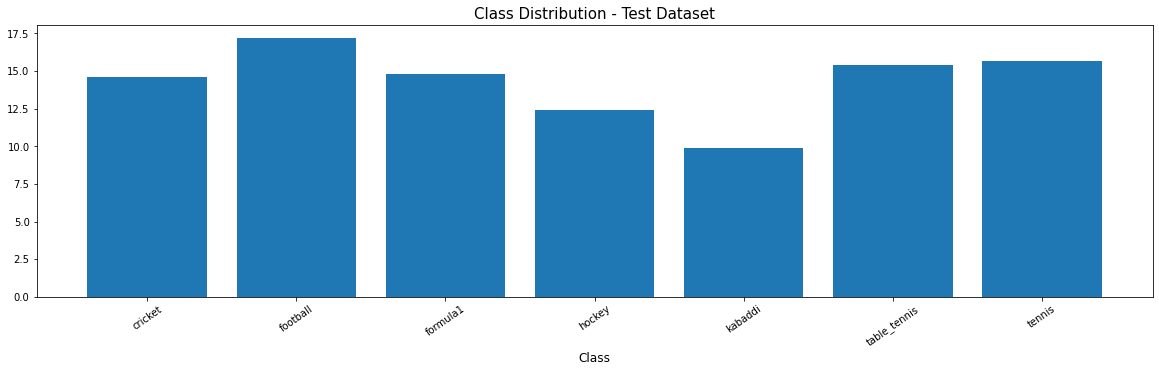

In [15]:
special_df = df
train, test = train_test_split(special_df, stratify=special_df["Label"], test_size=0.2)
train_prop = class_proportion(train)
test_prop = class_proportion(test)

plt.figure(figsize=(20,5))
plt.title('Class Distribution - Train Dataset', fontsize = 15)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=35)
plt.bar(x=train_prop["Label"], height=train_prop["Proportion"])

plt.figure(figsize=(20,5))

plt.title('Class Distribution - Test Dataset', fontsize = 15)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=35)
plt.bar(x=test_prop["Label"], height=test_prop["Proportion"])

plt.show()

In [17]:
train, valid = train_test_split(train, stratify=train["Label"], test_size=0.2)

In [18]:
size = 32
count_generated = 14
image_shape = (size, size)

In [19]:
def load_images(df):
    count_imgs = df.shape[0]        
    labels = np.ndarray(count_imgs)
    print(count_imgs)
    dataset = np.ndarray(shape=(count_imgs, size, size, 3), dtype=np.float32)
    X = []
    i=0
    p=0
    for img_row in tqdm(df.iterrows()):
        img = Image.open(img_row[1]["Path"])
        img = img.resize(image_shape)
        img = np.array(img)
        dataset[i] = img 
        labels[i] = img_row[1]["LabelNumber"]
        i+=1
        p+=1
    return dataset, labels

In [20]:
X_train, y_train = load_images(train)  

2301


2301it [00:20, 111.41it/s]


In [21]:
X_valid, y_valid = load_images(valid)

576


576it [00:04, 115.61it/s]


In [22]:
X_test, y_test = load_images(test)

900


900it [00:08, 110.35it/s]


In [23]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [24]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization

In [25]:
model1 = Sequential()

model1.add(Conv2D(filters=20, kernel_size=3, padding="same", activation="relu", input_shape=[size, size, 3]))
model1.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))
model1.add(Conv2D(filters=30, kernel_size=3, padding="same", activation="relu"))
model1.add(MaxPool2D())
model1.add(Flatten())
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=count_classes, activation='softmax'))

model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ["accuracy"])
model1.summary()

2022-09-10 17:31:53.741726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 17:31:53.890868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 17:31:53.891897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 17:31:53.893542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 20)        560       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        11584     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 30)        17310     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [26]:
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

2022-09-10 17:32:05.260664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-10 17:32:06.598167: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 8s 24ms/step - loss: 15.5018 - accuracy: 0.1921 - val_loss: 1.9509 - val_accuracy: 0.2049
Epoch 2/20
18/18 [==============================] - 0s 8ms/step - loss: 1.8965 - accuracy: 0.2282 - val_loss: 1.8329 - val_accuracy: 0.2639
Epoch 3/20
18/18 [==============================] - 0s 8ms/step - loss: 1.7209 - accuracy: 0.3464 - val_loss: 1.6757 - val_accuracy: 0.3715
Epoch 4/20
18/18 [==============================] - 0s 8ms/step - loss: 1.5863 - accuracy: 0.4024 - val_loss: 1.5699 - val_accuracy: 0.4392
Epoch 5/20
18/18 [==============================] - 0s 8ms/step - loss: 1.4879 - accuracy: 0.4463 - val_loss: 1.5294 - val_accuracy: 0.4514
Epoch 6/20
18/18 [==============================] - 0s 8ms/step - loss: 1.4043 - accuracy: 0.4741 - val_loss: 1.4811 - val_accuracy: 0.4722
Epoch 7/20
18/18 [==============================] - 0s 8ms/step - loss: 1.3203 - accuracy: 0.5167 - val_loss: 1.4853 - val_accuracy: 0.4549
Epoch 8/20
18/18 [===========

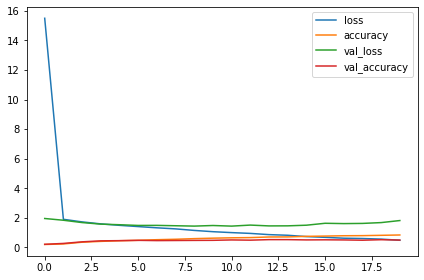

In [27]:
batch_size = 128
epochs = 20
history = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback1], epochs=epochs, batch_size=batch_size)

show_history(history)

In [28]:
model1.load_weights("weights.best.tf5")

In [29]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

29/29 [==============================] - 0s 4ms/step - loss: 1.5197 - accuracy: 0.4967
Test accuracy:  0.49666666984558105


In [30]:
model2 = Sequential()

model2.add(Conv2D(500,(3,3),padding='same',activation='relu',input_shape=(size,size,3)))
model2.add(MaxPool2D())

model2.add(Conv2D(500,(3,3),padding='same',activation='relu'))
model2.add(MaxPool2D())
model2.add(Conv2D(300,(3,3),padding='same',activation='relu'))

model2.add(Conv2D(500,(3,3),padding='same',activation='relu'))
model2.add(MaxPool2D())

model2.add(Flatten())

model2.add(Dense(320,activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(160,activation='relu'))
model2.add(Dense(160,activation='relu'))
model2.add(Dense(count_classes,activation='softmax'))

#op = tf.keras.optimizers.Adam(learning_rate=0.01)

model2.compile(optimizer="adam",loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 500)       14000     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 500)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 500)       2250500   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 500)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 300)         1350300   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 500)         1350500   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 500)        

Epoch 1/20
9/9 [==============================] - 7s 444ms/step - loss: 19.4595 - accuracy: 0.1408 - val_loss: 1.9397 - val_accuracy: 0.1823
Epoch 2/20
9/9 [==============================] - 1s 78ms/step - loss: 1.9381 - accuracy: 0.1756 - val_loss: 1.9176 - val_accuracy: 0.2622
Epoch 3/20
9/9 [==============================] - 1s 78ms/step - loss: 1.8972 - accuracy: 0.2355 - val_loss: 1.8216 - val_accuracy: 0.2969
Epoch 4/20
9/9 [==============================] - 1s 78ms/step - loss: 1.7760 - accuracy: 0.2960 - val_loss: 1.6780 - val_accuracy: 0.3368
Epoch 5/20
9/9 [==============================] - 1s 78ms/step - loss: 1.6396 - accuracy: 0.3711 - val_loss: 1.4945 - val_accuracy: 0.4444
Epoch 6/20
9/9 [==============================] - 1s 78ms/step - loss: 1.4732 - accuracy: 0.4537 - val_loss: 1.3805 - val_accuracy: 0.5104
Epoch 7/20
9/9 [==============================] - 1s 79ms/step - loss: 1.3441 - accuracy: 0.5211 - val_loss: 1.2884 - val_accuracy: 0.5486
Epoch 8/20
9/9 [=========

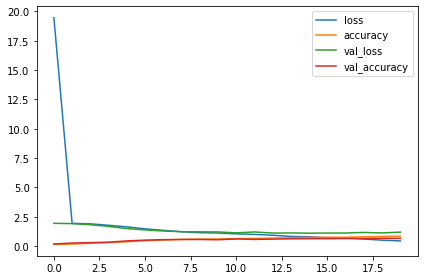

In [31]:
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights2.best.tf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)
batch_size = 256
epochs = 20
history = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback2], epochs=epochs, batch_size=batch_size)

show_history(history)

In [32]:
model2.load_weights("weights2.best.tf5")

In [33]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

29/29 [==============================] - 1s 8ms/step - loss: 1.1514 - accuracy: 0.6289
Test accuracy:  0.6288889050483704


In [34]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import MaxPool1D, MaxPool3D

In [35]:
model3 = VGG16(weights='imagenet', include_top=False, input_shape=(size,size,3))
for layer in model3.layers:
    layer.trainable=False

output=model3.output
x = output

x = Dense(160,activation='relu')(x)
x = Dropout(0.03)(x)

x = Dense(160,activation='relu')(x)
x = Dropout(0.08)(x)

x = Flatten()(x)

output_layer = Dense(count_classes,activation='softmax')(x)

#op = tf.keras.optimizers.Adam(learning_rate=0.05)

model3 = Model(inputs=model3.input, outputs=output_layer)
model3.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
model3.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

Epoch 1/20
72/72 [==============================] - 2s 18ms/step - loss: 5.6595 - accuracy: 0.3351 - val_loss: 2.4619 - val_accuracy: 0.4601
Epoch 2/20
72/72 [==============================] - 1s 10ms/step - loss: 1.6375 - accuracy: 0.5554 - val_loss: 2.1424 - val_accuracy: 0.4497
Epoch 3/20
72/72 [==============================] - 1s 10ms/step - loss: 1.0034 - accuracy: 0.6806 - val_loss: 1.9243 - val_accuracy: 0.5156
Epoch 4/20
72/72 [==============================] - 1s 10ms/step - loss: 0.6665 - accuracy: 0.7753 - val_loss: 1.9830 - val_accuracy: 0.5087
Epoch 5/20
72/72 [==============================] - 1s 10ms/step - loss: 0.4661 - accuracy: 0.8405 - val_loss: 1.9886 - val_accuracy: 0.5174
Epoch 6/20
72/72 [==============================] - 1s 13ms/step - loss: 0.3776 - accuracy: 0.8740 - val_loss: 2.0243 - val_accuracy: 0.5174
Epoch 7/20
72/72 [==============================] - 1s 10ms/step - loss: 0.2777 - accuracy: 0.9109 - val_loss: 2.0929 - val_accuracy: 0.5347
Epoch 8/20
72

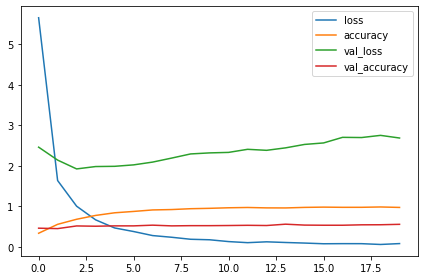

In [36]:
model_checkpoint_callback3= tf.keras.callbacks.ModelCheckpoint('vgg16.h5',monitor='val_accuracy',save_best_only=True,period=1)


batch_size = 32
epochs = 20
history = model3.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback3], epochs=epochs, batch_size=batch_size)

show_history(history)

In [37]:
model3.load_weights("vgg16.h5")

In [38]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy: ', test_acc)

29/29 [==============================] - 1s 11ms/step - loss: 2.3506 - accuracy: 0.5589
Test accuracy:  0.5588889122009277
